In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
sm = stepmodel.read_zip(training_folder + r'model/base/walk_model.zip'.format(scen=scenario))

zones: 100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 31.57it/s]


In [5]:
sm.volumes = distribution.volumes

# rail submodel

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

# strategy finder

In [7]:
rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
rail.links= rail.links.loc[rail.links['a'] != rail.links['b']]

In [8]:
rail.nodes.index.name='index'
rail.step_strategy_finder()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:37<00:00,  2.91it/s]


# assignment

In [9]:
rail.nodes.index.name='index'
rail.step_strategy_assignment('pt_captive')

100%|███████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 100.69it/s]


In [10]:
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
from IPython.core import display
import numpy as np
import networkx as nx

rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))

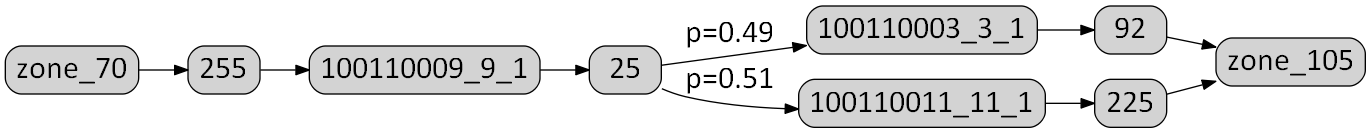

In [11]:
header = """
ratio = fill; 
node [style="filled,rounded" ,shape="record", fontname = "calibri", fontsize=24,];
edge[ fontname = "calibri", fontsize=24];
ranksep = "0.5";
rankdir="LR";
"""
origin, destination='zone_70',  'zone_105'
a = rail.get_aggregated_edges(origin, destination)
a['l'] = 'p=' + np.round(a['p'], 2).astype(str) #+ '\nh:' + a['h'].astype(str)
a.loc[a['p'] == 1, 'l'] = ''

odg = nx.DiGraph()
for e in a.to_dict(orient='records'):
    odg.add_edge(e['i'], e['j'], label=e['l'])
name='test'
dot_string = nx.nx_pydot.to_pydot(odg).to_string().replace('{', '{' + header)
src = Source(dot_string,format='png')
display.Image(filename=src.render(name))

In [12]:
self = rail
edges = self.optimal_strategy_edges[['i', 'j', 'f', 'c']].copy()
edges = edges.loc[self.optimal_strategy_sets.loc[destination]]
edges['ix'] = edges.index

# removing the edges that are non relevant (p<1e-6)
f_total = edges.groupby('i')[['f']].sum()
edges = pd.merge(edges, f_total, left_on='i', right_index=True, suffixes=['', '_total'])
edges['p'] = np.round(edges['f'] / edges['f_total'], 6)
edges = edges.loc[edges['p'] > 0]

In [13]:
#restriction to the origin
g = nx.DiGraph()
for e in edges.to_dict(orient='records'):
    g.add_edge(e['i'], e['j'])

paths = list(nx.all_simple_paths(g, source=origin, target=destination))
nodes = set.union(*[set(p) for p in paths])
ode = edges.loc[edges['i'].isin(nodes) & edges['j'].isin(nodes)]

In [14]:
rail.links.groupby(['a', 'b', 'trip_id']).first()

index  link_sequence  departure_time  \
a   b   trip_id                                                      
0   168 800_C_RapidTransit_1   5147              3         31500.0   
    181 800_C_RapidTransit_0   5143             12         32100.0   
    283 100110001_1_0          4168              1         27420.0   
100 229 100110012_12_0         4837              5         27180.0   
    258 100110006_6_2          4493             11         27480.0   
...                             ...            ...             ...   
98  191 100110002_2_3          4290             19         28320.0   
        100110003_3_2          4351             17         28440.0   
    76  100110002_2_2          4255              8         27480.0   
99  227 800_C_RapidTransit_3   5166              1         29940.0   
    53  100112013_T3A_0        5053              1         27240.0   

                              pickup_type  arrival_time  drop_off_type   time  \
a   b   trip_id                                                                 
0   168 800_C_RapidTransit_1            0       31680.0              0  180.0   
    181 800_C_RapidTransit_0            0       32220.0              0  120.0   
    283 100110001_1_0                   0       27540.0              0  120.0   
100 229 100110012_12_0                  0       27300.0              0  120.0   
    258 100110006_6_2                   0       27600.0              0  120.0   
...                                   ...           ...            ...    ...   
98  191 100110002_2_3                   0       28440.0              0  120.0   
        100110003_3_2                   0       28560.0              0  120.0   
    76  100110002_2_2                   0       27600.0              0  120.0   
99  227 800_C_RapidTransit_3            0       30060.0              0  120.0   
    53  100112013_T3A_0                 0       27360.0              0  120.0   

                              headway            pattern_id  \
a   b   trip_id                                               
0   168 800_C_RapidTransit_1      225  800:C:RapidTransit_1   
    181 800_C_RapidTransit_0      300  800:C:RapidTransit_0   
    283 100110001_1_0              95         100110001:1_0   
100 229 100110012_12_0            129        100110012:12_0   
    258 100110006_6_2             112         100110006:6_2   
...                               ...                   ...   
98  191 100110002_2_3             116         100110002:2_3   
        100110003_3_2             106         100110003:3_2   
    76  100110002_2_2             116         100110002:2_2   
99  227 800_C_RapidTransit_3      200  800:C:RapidTransit_3   
    53  100112013_T3A_0           212       100112013:T3A_0   

                                        route_id  ... route_color  \
a   b   trip_id                                   ...               
0   168 800_C_RapidTransit_1  800:C:RapidTransit  ...      F3D311   
    181 800_C_RapidTransit_0  800:C:RapidTransit  ...      F3D311   
    283 100110001_1_0                100110001:1  ...      FFCD00   
100 229 100110012_12_0              100110012:12  ...      007852   
    258 100110006_6_2                100110006:6  ...      6ECA97   
...                                          ...  ...         ...   
98  191 100110002_2_3                100110002:2  ...      003CA6   
        100110003_3_2                100110003:3  ...      837902   
    76  100110002_2_2                100110002:2  ...      003CA6   
99  227 800_C_RapidTransit_3  800:C:RapidTransit  ...      F3D311   
    53  100112013_T3A_0            100112013:T3A  ...      FF7E2E   

                             route_text_color      road_a      road_b  \
a   b   trip_id                                                         
0   168 800_C_RapidTransit_1           000000    21663181    34817060   
    181 800_C_RapidTransit_0           000000    21663181    27233853   
    283 100110001_1_0                  000000  67505770